# モジュールのインポート

In [61]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# 必要情報を入力

In [20]:
# 各フォルダの読み込み
# folder_list = glob.glob(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\data\*')
folder_list = glob.glob(r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelタイトル
graph_title = 'raman'
# excelファイルの保存先のパス
# excel_path = r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\\' + graph_title + '.xlsx'
excel_path = r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\\' + graph_title + '.xlsx'

# データの読み込み

In [21]:
file_dic = {}
for n, folder in enumerate(folder_list):
    file_dic[f'data_{n+1}'] = glob.glob(folder + '\*')

df_list = []

for folder in file_dic:
    # フォルダ内にファイルがある場合
    if len(file_dic[folder]) > 0:
        # 各種データ保存用のディクショナリを作成
        data_dic = {}
        
        # テクストファイルの読み込み
        for file in file_dic[folder]:
            # ファイル名の切り取り
            file_name = re.split('[\\\\.]', file)[8]

            # 一時保存用リストの作成
            temp_list = []

            # スペクトルデータの読み込み
            with open(file, encoding='utf-8') as f:
                for row in f:
                    row = row.strip()
                    temp_list.append(re.split(sep, row)) 
            temp_list = temp_list[32:869]

            # ディクショナリへデータの格納
            data_dic[file_name] = temp_list

        # 空のデータフレームを作成
        df = pd.DataFrame()

        # フォルダ内データをデータフレームに追加
        for key in data_dic:
            intensity_list = []
            wave_list = []

            for n in range(len(data_dic[key])):
                intensity_list.append(data_dic[key][n][3])

            for n in range(len(data_dic[key])):
                wave_list.append(data_dic[key][n][0])

            df['Raman Shift'] = wave_list
            df[key] = intensity_list

        df = df.astype(float)
        df = df.sort_values(by=['Raman Shift'], ascending=True).reset_index(drop=True)

        df_list.append(df)

    else:
        break

# グラフの可視化

In [9]:
# X軸の最大・最小の設定
XLIM_MIN = 0
XLIM_MAX = 1
# Y軸の最大・最小の設定
YLIM_MIN = -1000
YLIM_MAX = 4000
# 軸ラベルの設定
XLABEL = 'Raman Shift [cm^-1]'
YLABEL = 'Intensity [a.u.]'
# グラフサイズ
GRAPH_SIZE = (8, 6)
# フォントサイズ
FONTS_SIZE = 14

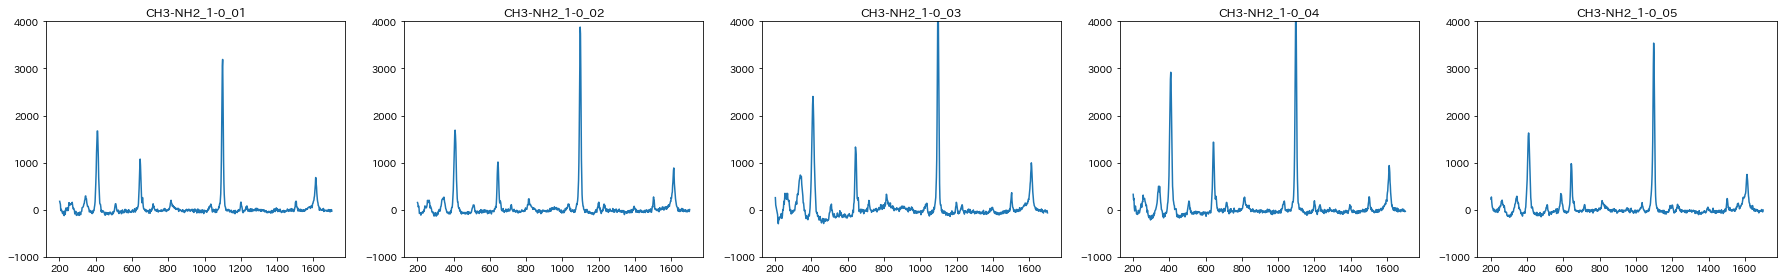

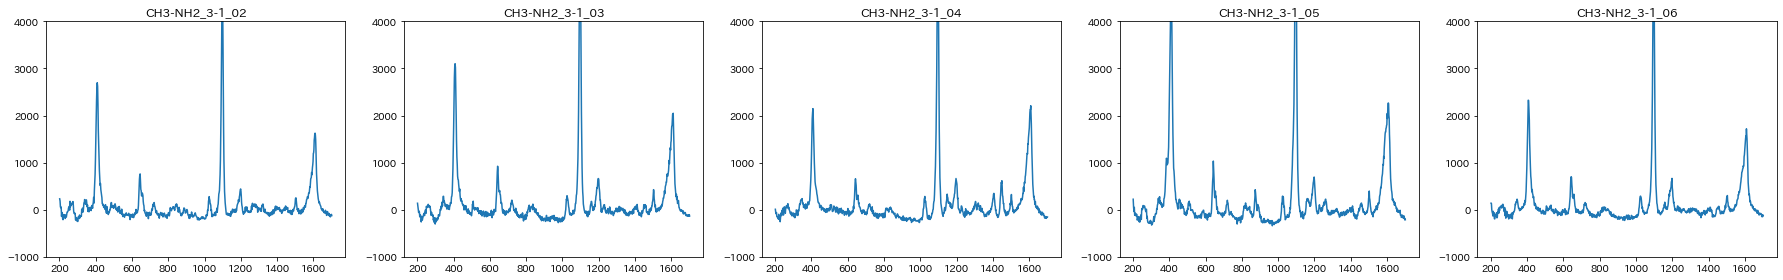

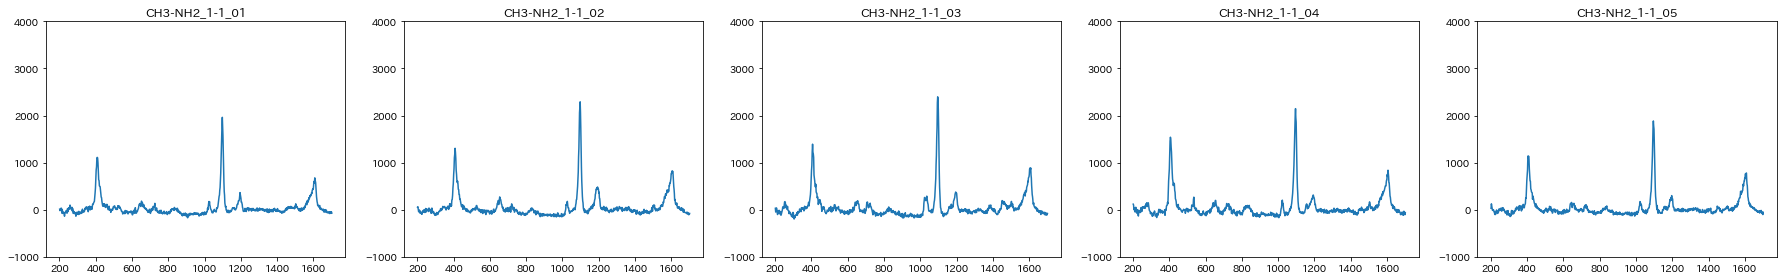

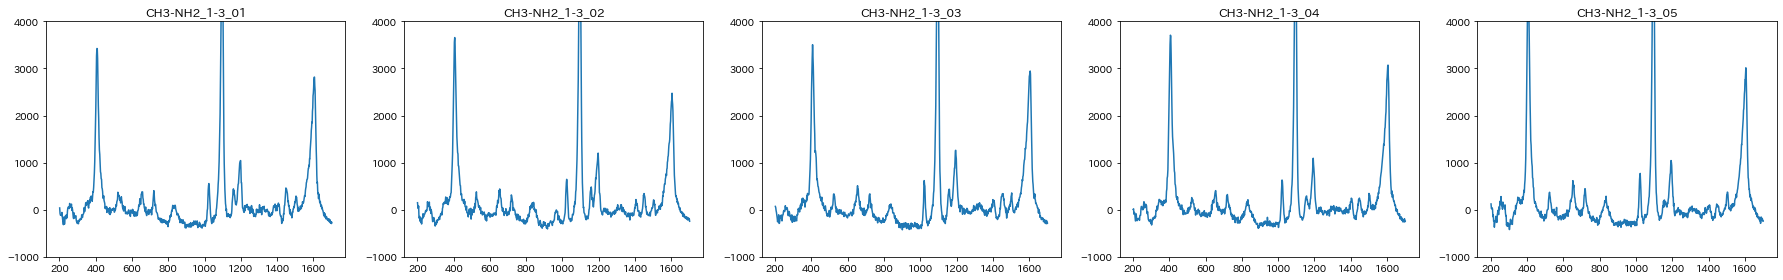

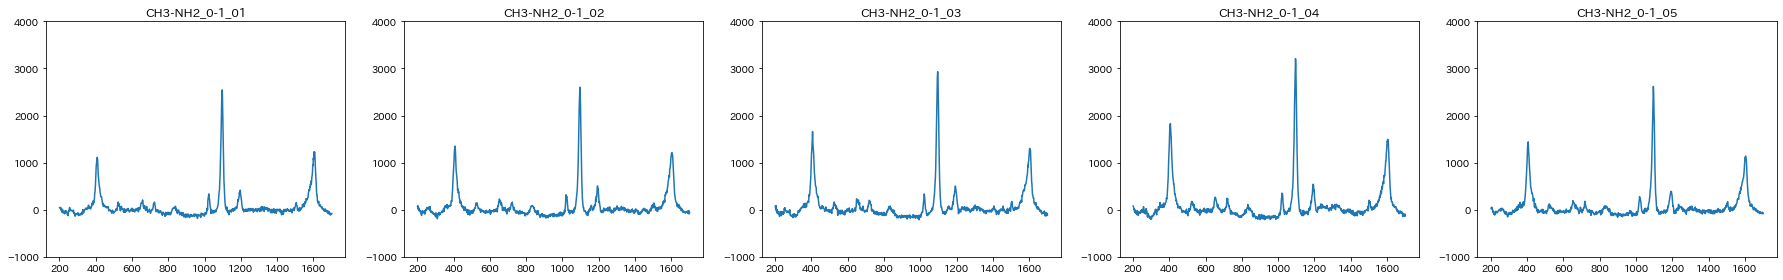

In [10]:
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
    plt.figure(figsize=(25, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.plot(df['Raman Shift'] , df[yaxis_list[i]])
        plt.title(yaxis_list[i])
        plt.ylim(YLIM_MIN, YLIM_MAX)

        # x,y軸の目盛り設定
        
    # plt.xlabel(XLABEL, fontsize=FONTS_SIZE)
    # plt.ylabel(YLABEL, fontsize=FONTS_SIZE)
    # plt.xticks(fontsize=FONTS_SIZE)
    # plt.yticks(fontsize=FONTS_SIZE)
    plt.tight_layout()
    plt.show()

# データの前処理

In [22]:
scaled_df_list = []

for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = MinMaxScaler()
    series = scaler.fit_transform(df[yaxis_list])
    scaled_df = pd.DataFrame(series)
    scaled_df.columns = yaxis_list
    scaled_df.insert(0, 'Raman Shift', df['Raman Shift'])


    scaled_df_list.append(scaled_df)

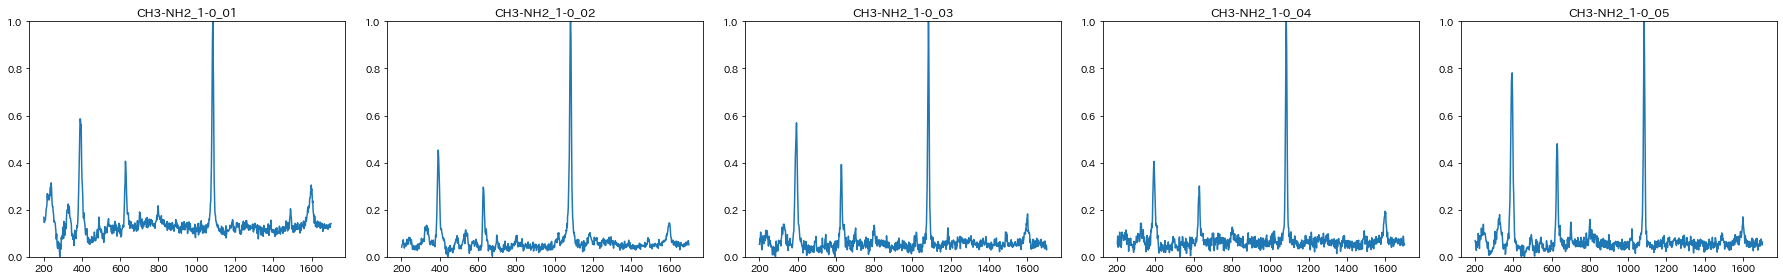

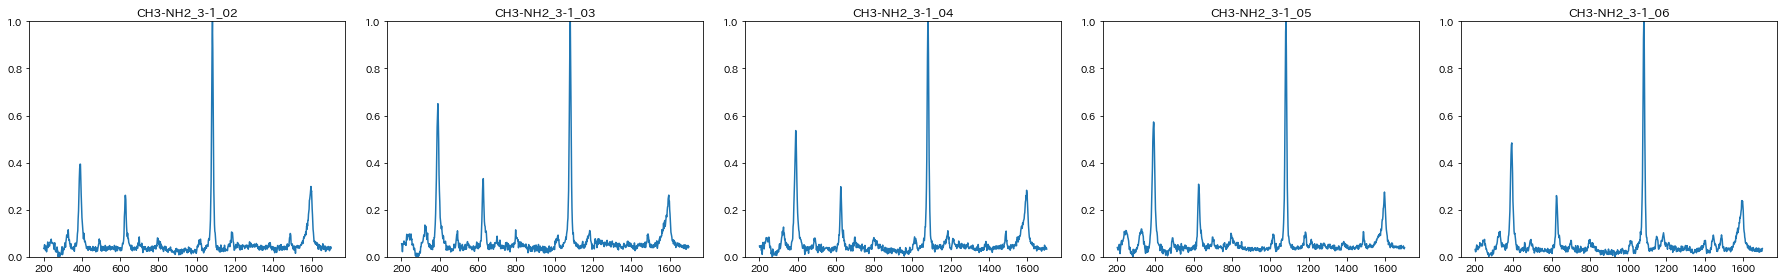

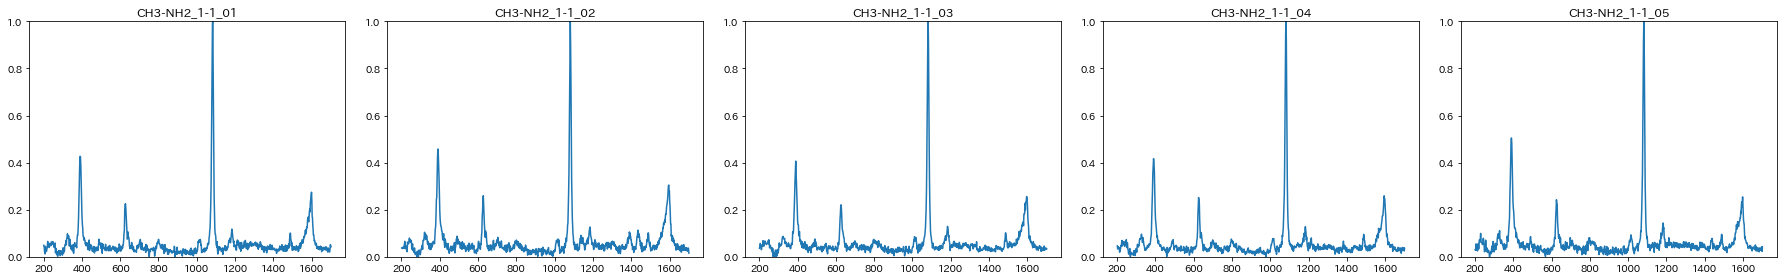

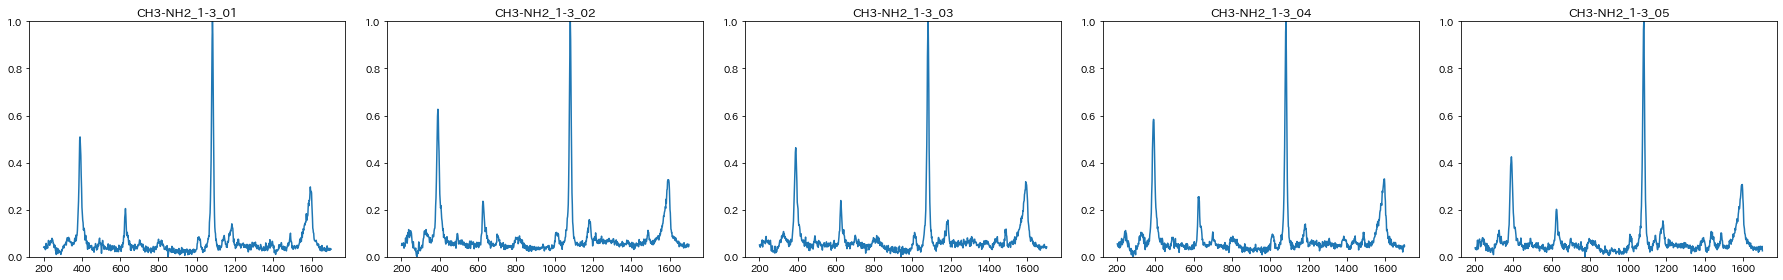

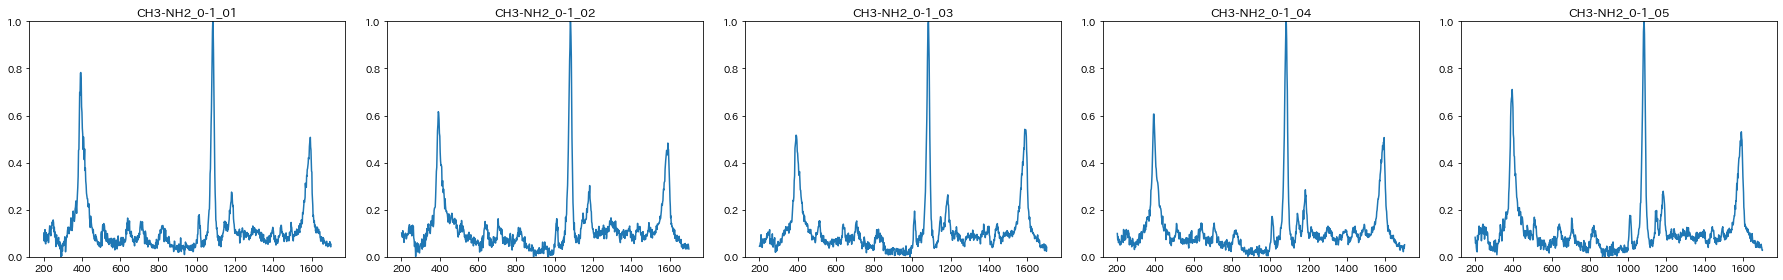

In [12]:
# Y軸の最大・最小の設定
YLIM_MIN = 0
YLIM_MAX = 1
for df in scaled_df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
    plt.figure(figsize=(25, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.plot(df['Raman Shift'] , df[yaxis_list[i+25]])
        plt.title(yaxis_list[i])
        plt.ylim(YLIM_MIN, YLIM_MAX)

        # x,y軸の目盛り設定
        
    # plt.xlabel(XLABEL, fontsize=FONTS_SIZE)
    # plt.ylabel(YLABEL, fontsize=FONTS_SIZE)
    # plt.xticks(fontsize=FONTS_SIZE)
    # plt.yticks(fontsize=FONTS_SIZE)
    plt.tight_layout()
    plt.show()

In [23]:
RAMAN_SHIFT = df_list[0]['Raman Shift']
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']

for n, df in enumerate(scaled_df_list):
    df.loc[-1] = int(n)

pca_df = pd.concat(scaled_df_list, axis=1)
pca_df = pca_df.drop(['Raman Shift'], axis=1)
pca_df = pca_df.T
pca_label = pca_df[-1]
pca_df = pca_df.drop(-1, axis=1)
pca_df.columns = RAMAN_SHIFT

# PCA

In [24]:
pca = PCA(n_components=2)

X = pca.fit_transform(pca_df.values)
result_df = pd.DataFrame(X)
result_df.columns = ['PC1', 'PC2']
result_df['label'] = pca_label.values
result_df.head()

,PC1,PC2,label
0,1.363548,-0.218933,0.0
1,1.323049,-0.255789,0.0
2,1.293447,-0.165515,0.0
3,1.453183,-0.178837,0.0
4,1.321904,-0.235845,0.0


In [25]:
data_1 = result_df[result_df['label'] == 0]
data_2 = result_df[result_df['label'] == 1]
data_3 = result_df[result_df['label'] == 2]
data_4 = result_df[result_df['label'] == 3]
data_5 = result_df[result_df['label'] == 4]

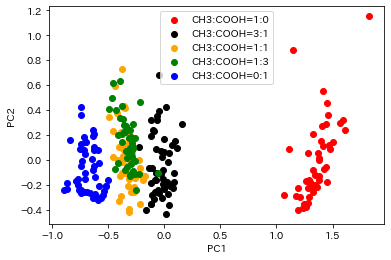

In [26]:
plt.scatter(data_1['PC1'], data_1['PC2'], c='red', label='CH3:COOH=1:0')
plt.scatter(data_2['PC1'], data_2['PC2'], c='black', label='CH3:COOH=3:1')
plt.scatter(data_3['PC1'], data_3['PC2'], c='orange', label='CH3:COOH=1:1')
plt.scatter(data_4['PC1'], data_4['PC2'], c='green', label='CH3:COOH=1:3')
plt.scatter(data_5['PC1'], data_5['PC2'], c='blue', label='CH3:COOH=0:1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.show()

In [14]:
# 寄与率の算出
df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=['PC1', 'PC2'])
df_exp_var_ratio.head()

,PC1,PC2
0,0.745628,0.095906


In [15]:
#各主成分の固有ベクトル
pca_vec_df = pd.DataFrame(pca.components_, columns=pca_df.columns, index=['PC1', 'PC2'])
pca_vec_df

Raman Shift,188.905169,190.953919,193.001985,195.049368,197.096067,199.142083,201.187416,203.232067,205.276035,207.319322,...,1677.123736,1678.702978,1680.281751,1681.860055,1683.437890,1685.015257,1686.592156,1688.168586,1689.744549,1691.320043
PC1,0.005484,0.001349,-0.001184,-0.001234,-0.004005,-0.005613,-0.004443,-0.006564,-0.007713,-0.007599,...,-0.011793,-0.010664,-0.011848,-0.011356,-0.011065,-0.010796,-0.011335,-0.012059,-0.011777,-0.011347
PC2,0.055485,0.050930,0.044446,0.040811,0.038334,0.040230,0.037819,0.039357,0.041415,0.038282,...,0.031141,0.028662,0.029922,0.028089,0.031688,0.030712,0.029332,0.029532,0.030112,0.026740


<AxesSubplot:xlabel='Raman Shift'>

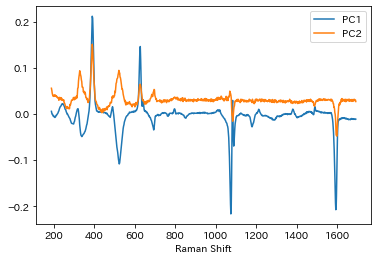

In [16]:
pca_vec_df.T.plot()

In [17]:
pca.explained_variance_

array([0.51151011, 0.06579242])

# 予測

In [44]:
def pca_svm(n_comp, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=pca_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)


    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

In [27]:
# n_components = 2
raitio_2, _, cm_2, accuracy_2 = pca_svm(2, pca_df, pca_label)
print(raitio_2)
print(accuracy_2)

<AxesSubplot:>

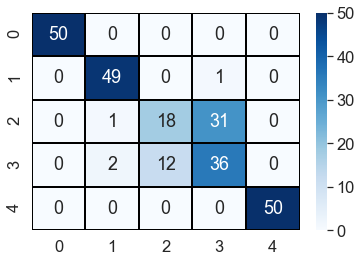

In [36]:
sns.set(font_scale=1.5)
sns.heatmap(cm_2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# PCA_SVMの検討

In [45]:
# n_components = 3
raitio_3, _, cm_3, accuracy_3 = pca_svm(3, pca_df, pca_label)
print(raitio_3)
print(accuracy_3)

        PC1       PC2       PC3
0  0.745628  0.095906  0.038216
0.852


<AxesSubplot:>

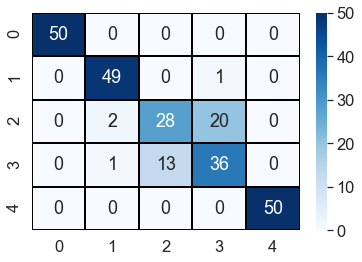

In [48]:
sns.set(font_scale=1.5)
sns.heatmap(cm_3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [50]:
# n_components = 5
raitio_5, _, cm_5, accuracy_5 = pca_svm(5, pca_df, pca_label)
print(raitio_5)
print(accuracy_5)

        PC1       PC2       PC3       PC4       PC5
0  0.745628  0.095906  0.038216  0.026761  0.007338
0.856


<AxesSubplot:>

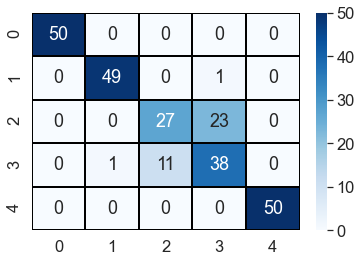

In [51]:
sns.set(font_scale=1.5)
sns.heatmap(cm_5, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# SVM単体での解析

In [56]:
def svm_only(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC()
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [58]:
cm_svm, accuracy_svm = svm_only(pca_df, pca_label)
print('Accuracy:', accuracy_svm)

Accuracy: 0.764


<AxesSubplot:>

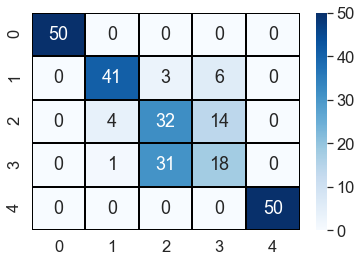

In [59]:
sns.set(font_scale=1.5)
sns.heatmap(cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# Linear Discriminant Analysis(LDA)

explained variance ratio (first two components): [0.93530942 0.05010735]


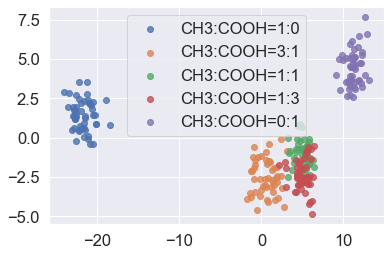

In [77]:
lda = LDA(n_components=2)
X_r2 = lda.fit(pca_df, pca_label).transform(pca_df)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

plt.figure()
for i, label_name in zip([0, 1, 2, 3, 4], label_list):
    plt.scatter(X_r2[pca_label == i, 0], X_r2[pca_label == i, 1], alpha=.8,
    label=label_name)

plt.legend(loc='best', scatterpoints=1)
plt.show()

In [73]:
def lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        lda_model = LDA(n_components=n_comp)
        lda_model.fit(train_x, train_y)
        y_pred = lda_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [74]:
cm_lda2, accuracy_lda2 = lda_prediction(2, pca_df, pca_label)
print('Accuracy:', accuracy_lda2)

Accuracy: 0.92


<AxesSubplot:>

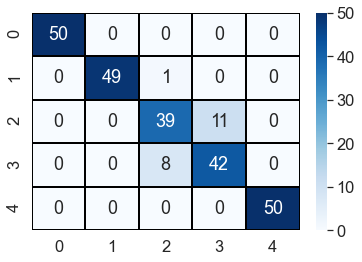

In [75]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda2, annot=True, cmap='Blues', linecolor='black', linewidths=1)

In [82]:
cm_lda3, accuracy_lda3 = lda_prediction(3, pca_df, pca_label)
print('Accuracy:', accuracy_lda3)

Accuracy: 0.92


<AxesSubplot:>

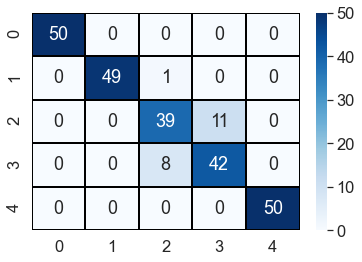

In [79]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda3, annot=True, cmap='Blues', linecolor='black', linewidths=1)

# DTWによるクラスタリング

In [ ]:
tslearn

# データのExcel化

In [157]:
# 規格化なしの場合
with pd.ExcelWriter(excel_path) as writer:
    for n, df in enumerate(df_list):
        df.to_excel(writer, sheet_name=f'data_{n+1}', index=False)

In [180]:
result_df.to_excel(r'C:\Users\west7\OneDrive\デスクトップ\自動処理用\result.xlsx', index=False)

In [181]:
pca_vec_df.T.to_excel(r'C:\Users\west7\OneDrive\デスクトップ\自動処理用\vector.xlsx', index=False)

In [15]:
# 規格化なしの場合
with pd.ExcelWriter(excel_path) as writer:
    for n, df in enumerate(df_list):
        df.to_excel(writer, sheet_name=f'data_{n+1}', index=False)

# 編集するエクセルの読み込み
wb = openpyxl.load_workbook(r'C:\Users\west7\OneDrive\デスクトップ\自動処理用\\' + graph_title + '.xlsx')
for n, df in enumerate(df_list):

    # 光源での規格化ありの場合
    if std_list:
        yaxis_list = [y for y in df.columns if '_std' in y]
        MAX_ROW = len(df['Wavelength']) + 1
        START_COLUMN = len(yaxis_list) + 3

    # 光源での規格化なしの場合
    else:
        yaxis_list = [y for y in df.columns if not 'Wavelength' in y]
        MAX_ROW = len(df['Wavelength']) + 1
        START_COLUMN = 2

    END_COLUMN = START_COLUMN + len(yaxis_list)
    sheet = wb[f'data_{n+1}']

    # 散布図の作成
    chart_obj = openpyxl.chart.ScatterChart()

    # x軸データの参照
    x = openpyxl.chart.Reference(sheet, min_col = 1, min_row = 2, max_col = 1, max_row = MAX_ROW)

    for cell in range(START_COLUMN, END_COLUMN):
        y = openpyxl.chart.Reference(sheet, min_col = cell, min_row = 2, max_col = cell, max_row = MAX_ROW)
        series_obj = openpyxl.chart.Series(y, x)
        chart_obj.series.append(series_obj)

    # グラフの位置
    chart_obj.y = 10
    chart_obj.x = 800
    # グラフのサイズ
    chart_obj.w = 240
    chart_obj.h = 200
    # x軸のスケール設定
    chart_obj.x_axis.scaling.min = 300
    chart_obj.x_axis.scaling.max = 1100
    # 軸の目盛向き設定
    chart_obj.x_axis.majorTickMark = "in"
    chart_obj.y_axis.majorTickMark = "in"
    # 軸線の設定
    chart_obj.x_axis.spPr = GraphicalProperties(ln =LineProperties(solidFill="000000", w=1*12700))
    chart_obj.y_axis.spPr = GraphicalProperties(ln =LineProperties(solidFill="000000", w=1*12700))
    # グリッド線の設定
    chart_obj.x_axis.majorGridlines.spPr = GraphicalProperties(ln=LineProperties(solidFill= "B3B3B3", w=0.01*12700))
    chart_obj.y_axis.majorGridlines.spPr = GraphicalProperties(ln=LineProperties(solidFill= "B3B3B3", w=0.01*12700))
    # 枠線を消す
    # chart_obj.graphical_properties = GraphicalProperties(ln=LineProperties(noFill=True))
    # 軸タイトル
    chart_obj.x_axis.title = 'Wavelength [nm]'
    chart_obj.y_axis.title = 'Intensity [a.u.]'

    # グラフのフォント設定
    font = Font(typeface='Arial')
    size = 1400 # 14 point size
    cp = CharacterProperties(latin=font, sz=size, b=False) # Try bold text
    pp = ParagraphProperties(defRPr=cp)
    rtp = RichText(p=[Paragraph(pPr=pp, endParaRPr=cp)])
    chart_obj.legend.textProperties = rtp
    chart_obj.y_axis.textProperties = rtp
    chart_obj.x_axis.textProperties = rtp
    chart_obj.x_axis.title.tx.rich.p[0].pPr = pp
    chart_obj.y_axis.title.tx.rich.p[0].pPr = pp

    # グラフの貼り付け、保存
    sheet.add_chart(chart_obj)

wb.save(r'C:\Users\west7\OneDrive\デスクトップ\自動処理用\\' + graph_title + '.xlsx')